In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
cmap = matplotlib.colormaps.get('tab10').colors
import torch
import torch_geometric as tg
from tqdm import trange
import ipywidgets as widgets
from ipywidgets.widgets import interact
plt.style.use('fullwidth.mplstyle')

In [2]:
import numpy as np
rng = np.random.default_rng()
import os
import torch_geometric as tg
import torch
from tqdm import trange
from scipy.spatial import KDTree
import networkx as nx

class PlaneAutoencoderDataset(tg.data.Dataset):
    '''
    This class bundles the creation and saving as well as loading of a dataset of 3D graphs. If an instance is created, the class will 
    check in root directory if the dataset is already processed. If not, the process() method will be called. Furthermore, the
    dataset will be loaded. If the dataset shall be calculated again, the process() method must be called explicitely.
    '''
    def __init__(self, root, n_graphs_per_type=100, transform=None, pre_transform=None, size=(5,5)):
        '''
        Args:
        - root (str): The directory where the dataset should be stored, divided into processed and raw dirs
        '''
        self.root = root
        self.n_graphs_per_type = n_graphs_per_type
        self.size = size    
        super().__init__(root, transform, pre_transform)
        
    @property
    def raw_file_names(self):
        '''
        If this file exists in the raw directory, the download will be skipped. Download not implemented.
        '''
        return 'raw.txt'
    
    @property
    def processed_file_names(self):
        '''
        If this file exists in the processed directory, processing will be skipped. 
        Note: This does smh not work, therefore files are ATM recalculated every time.
        '''
        return ['data_00000.pt']
    
    def download(self):
        '''
        Download not implemented.
        '''
        pass
    
    def len(self):
        '''
        Returns the number of graphs in the dataset.
        '''
        return len([f for f in os.listdir(os.path.join(self.root, 'processed')) if f.startswith('data')])
    
    def get(self, idx):
        '''
        Returns the graph at index idx. 
        '''
        data = torch.load(os.path.join(self.processed_dir, 'data_{:05d}.pt'.format(idx)))
        return data
    
    def process(self):
        '''
        Here creation, processing and saving of the dataset happens. 
        '''
        planeGraph = PlaneGraphGenerator(size=self.size) # Create the planeGraph object
        for n in trange(self.n_graphs_per_type * 5):
            # Get graph features:
            pos, edge_index, label, node_attr, edge_attr = planeGraph.process_lattice(planeGraph.lattice_types[n % 5])
            
            # Create data object:
            data = tg.data.Data(x          = torch.tensor(node_attr, dtype=torch.float), 
                                edge_index = torch.tensor(edge_index, dtype=torch.int64), 
                                y          = torch.tensor(label, dtype=torch.float), 
                                pos        = torch.tensor(pos, dtype=torch.float),
                                edge_attr  = torch.tensor(edge_attr, dtype=torch.float))
            # Save data object:
            torch.save(data, os.path.join(self.processed_dir, 'data_{:05d}.pt'.format(n)))

class PlaneGraphGenerator():
    def __init__(self, size=(5,5)):
        '''
        Args:
        - size (tuple): The size of the lattice in x,y direction. The lattice will be size[0] x size[1] large.
        '''
        self.size = np.array(size) + 3
        self.lattice_types = {
            0: {'name': 'mP', 'nodes': self._get_P_nodes, 'binding_angle':   0, 'scale': [0, 0]},
            1: {'name': 'oP', 'nodes': self._get_P_nodes, 'binding_angle':  90, 'scale': [0, 0]},
            2: {'name': 'oC', 'nodes': self._get_C_nodes, 'binding_angle':  90, 'scale': [0, 0]},
            3: {'name': 'tP', 'nodes': self._get_P_nodes, 'binding_angle':  90, 'scale': [1, 1]},
            4: {'name': 'hP', 'nodes': self._get_P_nodes, 'binding_angle': 120, 'scale': [1, 1]}
        }
        
    def _get_P_nodes(self, angle=90):
        '''
        Get the nodes of a primitive lattice.
        '''
        scaling = np.sin(np.radians(angle))
        vec1 = np.arange(0,self.size[0])
        vec2 = np.arange(0,self.size[1])*scaling
        a, b = np.meshgrid(vec1,vec2)
        nodes = np.stack([a,b],axis=-1) # Stack them in a new axis
        nodes = np.reshape(nodes, (-1, 2)) # Reshape to an arr of nodes with shape (#nodes, 2)
        return nodes

    def _get_C_nodes(self):
        '''
        Get the nodes of a centred lattice.
        '''
        P = self._get_P_nodes()
        extra = P + np.array([0.5,0.5])
        return np.row_stack((P, extra))
    

    def process_lattice(self, arg_dict):
        '''
        Method that processes a lattice of a given type. The method is called with a dictionary holding parameters for one of the lattice types. It contains the following keys:
            - name: The name of the lattice type
            - nodes: The method to get the fitting fundamental lattice nodes
            - binding_angle: binding angle alpha of the lattice type. angle are in degrees. 0° means to generate a independent random angle (0,180)°
            - scale: A list of scaling factors [x,y] for the lattice type. 0 means to generate a random scaling factor (0,2)
        '''
        # Get lattice angles
        angle = arg_dict['binding_angle']
        if angle == 0:
            angle = rng.uniform(46,89,1)
            
        # Get the fundamental lattice nodes
        if arg_dict['name'] in ['hP']:
            # For hP lattice we need to give the angle to the nodes method so that sheared connections are equally long
            nodes = arg_dict['nodes'](angle)
        else:
            nodes = arg_dict['nodes']()
        inside_mask = self._get_inside_mask(nodes)
        nodes = self._shear_nodes(nodes, angle)
        # Find random scale and apply gaussian noise to the lattice accordingly
        scale = np.array(arg_dict['scale'])
        scale = np.where(scale == 0, rng.uniform(0.3,3,2), scale)
        noise_level = 0.05 / scale  # At this step we scale the noise down, so that the scaling later on does not affect the noise level
        #nodes += rng.normal(0, noise_level, nodes.shape)
        
        nodes, labels, inside_mask = self._displace_node(nodes, inside_mask)
        # Find the connections between the nodes in a given radius
        cons= self._get_cons_in_radius(nodes, 1.3+np.mean(noise_level))
        # Apply the saved scaling
        nodes *= scale
        
        node_attr = self.get_node_attr(nodes, cons)
        nodes, labels, node_attr = nodes[inside_mask], labels[inside_mask], node_attr[inside_mask]
        cons = self._get_cons_in_radius(nodes, 1.3+np.mean(noise_level))
        edge_attr = self.get_edge_attr(nodes, cons)
        return nodes, cons, labels, node_attr, edge_attr

    def _displace_node(self, nodes, inside_mask):
        '''
        Method that dislaces one random node in the lattice by a random amount. Returns the new nodes and the label for classification. 
        The label is a one hot encoded array of shape (len(nodes)) where 1 markes the index od the displaced node.
        '''
        # Get random inside node 
        allowed_indices = np.where(inside_mask)[0]
        node_ind = rng.choice(allowed_indices)
        # Get random displacement
        displacement = rng.normal(0, 1, 2)
        # Assert that the displacement does not move the node out of the lattice (roughly)
        while np.any(nodes[node_ind] + displacement < np.min(nodes[inside_mask], axis=0)) or np.any(nodes[node_ind] + displacement > np.max(nodes[inside_mask], axis=0)):
            displacement = rng.normal(0, 1, 2)
        # Displace node, get label
        nodes = np.insert(nodes, node_ind, nodes[node_ind] + displacement, axis=0)
        inside_mask = np.insert(inside_mask, node_ind, True)
        #nodes[node_ind] += displacement
        labels = np.zeros(len(nodes))
        labels[node_ind] = 1
        return nodes, labels.reshape(-1,1), inside_mask
    
    def _get_cons_in_radius(self, nodes, radius):
        '''
        Get the connections in a radius as well as the total number of cons for each node.
        '''
        tree = KDTree(nodes)
        cons = tree.query_pairs(radius, output_type='ndarray', p=2)
        cons = cons.T
        cons = np.column_stack((cons, cons[::-1])) # Add the reverse connections
        return cons

    def _shear_nodes(self, nodes, binding_angle):
        '''
        Shear nodes by binding angle.
        '''
        delta = np.tan(np.radians(binding_angle))
        assert not np.any(delta == 0), 'Binding angle cannot be 0'
        nodes = nodes.astype(float)
        nodes = nodes + np.stack((nodes[:,1]/delta, np.zeros_like(nodes[:,1])), axis=1)
        return nodes

    def _add_defects(self, nodes, edge_index, labels):
        '''
        Method that adds up to 10% of random defects (i.e. missing nodes) to the lattice. Should be called after _get_*_graph() but before
        _get_edge_attr() and _get_node_attr().
        '''
        # Draw up to 10% of unique random indices for nodes to be removed
        drop_indices = rng.choice(np.arange(len(nodes)), rng.integers(len(nodes)//10), replace=False)
        # Remove the nodes and labels
        nodes = np.delete(nodes, drop_indices, axis=0)
        labels = np.delete(labels, drop_indices, axis=0)
        # Delete every connection that refers to a removed node
        edge_index = np.delete(edge_index, np.where(np.isin(edge_index, drop_indices))[1], axis=1)
        
        # As edge_index refers to the original node indices, we need to adjust the indices of most connections
        # For this we create a mapping from old indices to new indices
        old_to_new = np.arange(len(nodes) + len(drop_indices))  # Start with an array of original indices; [0,1,2,3,4,5,...]
        old_to_new[drop_indices] = -1  # Mark the indices of the nodes to be deleted; eg. drop_indices = [1,3] -> [0,-1,2,-1,4,5,...]
        old_to_new = np.cumsum(old_to_new != -1) - 1  # Create a cumulative sum array; cumsum([True, False, True, False, True, True,...]) -1 -> [1,1,2,2,3,4,...] -1 -> [0,0,1,1,2,3,...]
        
        # # Update edge indices to reflect new node indices through broadcasting
        edge_index = old_to_new[edge_index]
        return nodes, edge_index, labels
        
    def get_node_attr(self,nodes,cons):
        '''
        Method that returns the node attributes for each node in the graph. Should be called after creating the graph and adding defects.
        The node attributes have the shape (num_nodes, num_node_features). For each node, the node features are the following:
        - The bond orientational order parameters for l=4,6,8,10 (4 features)
        '''
        G = nx.Graph()
        G.add_edges_from(cons.T)
        boo_arr = np.zeros((len(nodes), 5), dtype=complex)
        n_neighbors = np.zeros(len(nodes))
        for i in range(len(nodes)):
            if i not in G.nodes:
                # node is not connected to any other node, return 0
                boo_arr[i] = np.zeros(5)
                n_neighbors[i] = 0
                continue
            # iterate over all nodes, get their neighbors
            neighbors = list(G.neighbors(i))
            n_neighbors[i] = len(neighbors)
            # calculate the bond orientational order parameters
            boo_ = np.zeros(5, dtype=complex)
            for n in neighbors:
                angle = np.arctan2(nodes[n,1] - nodes[i,1], nodes[n,0] - nodes[i,0])
                boo_ += np.array([np.exp(1j*2*angle), np.exp(1j*4*angle), np.exp(1j*6*angle), np.exp(1j*8*angle), np.exp(1j*10*angle)])   
            boo_arr[i] = np.abs(boo_ / len(neighbors)) 
        boo_arr = np.real(boo_arr)
        # return boo_arr
        return np.column_stack((boo_arr, n_neighbors))
        
    
    def get_edge_attr(self,nodes,cons):
        '''
        Method that returns the edge attributes for each edge in the graph. Should be called after creating the graph and adding defects.
        Returns an array of shape (len(edge_index[0])= #Edges, 1) with the length of each edge.
        '''
        # Get the edge vectors for each edge
        edge_vectors = nodes[cons[0]] - nodes[cons[1]]
        return np.linalg.norm(edge_vectors, axis=1).reshape(-1,1)   
    
    def _get_inside_mask(self, nodes):
        '''
        Method that returns the indices of the border nodes of the lattice. 
        '''
        mask = np.any(np.logical_or(nodes < np.array([1,1]), nodes >= self.size-2), axis=1)
        return ~mask
 


def plot(nodes, cons, labels=None, scores=None):
    '''
    Plot the graph.
    '''
    fig, ax = plt.subplots()
    ax.scatter(nodes[:,0], nodes[:,1], c='black')
    for con in cons.T:
        ax.plot(nodes[con,0], nodes[con,1], c='black')
    labels = labels.flatten()
    if labels is not None:
        ax.plot(nodes[labels==1,0], nodes[labels==1,1], c='red', markersize=10, marker='o', linestyle='None')
    if scores is not None:
        ax.plot(nodes[np.argmax(scores),0], nodes[np.argmax(scores),1], c='blue', markersize=10, marker='x')
    ax.set_aspect('equal')
    ax.grid()

In [3]:
n = 250
dataset = PlaneAutoencoderDataset("autoencoder_2d", n_graphs_per_type=n, size=(10,10))
# delete the processed folder when you want to recalculate the dataset
# import shutil
# shutil.rmtree("autoencoder_2d/processed")
# dataset.process()
dataset[0]

C:\Users\steph\AppData\Local\Temp\ipykernel_9304\1499384556.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(os.path.join(self.processed_dir, 'data_{:0

Data(x=[101, 6], edge_index=[2, 188], edge_attr=[188, 1], y=[101, 1], pos=[101, 2])

## NN cell

In [10]:
train_loader = tg.loader.DataLoader(dataset[:n*4], batch_size=16, shuffle=True)
test_loader = tg.loader.DataLoader(dataset[n*4:], batch_size=16, shuffle=True)
device= 'cuda' if torch.cuda.is_available() else 'cpu'
num_features = dataset.num_features
alpha = 0.5 # weight of the attribute loss


class dominant(torch.nn.Module):
    def __init__(self):
        super(dominant, self).__init__()
        self.encoder = torch.nn.ModuleList()
        self.encoder.append(tg.nn.GINEConv(torch.nn.Linear(num_features, 4), edge_dim=1))
        self.encoder.append(tg.nn.GINEConv(torch.nn.Linear(4, 3), edge_dim=1))
        self.encoder.append(tg.nn.GINEConv(torch.nn.Linear(3, 2), edge_dim=1))

        self.attr_decoder =torch.nn.ModuleList()
        self.attr_decoder.append(tg.nn.GINEConv(torch.nn.Linear(2, 3), edge_dim=1))
        self.attr_decoder.append(tg.nn.GINEConv(torch.nn.Linear(3, 4), edge_dim=1))
        self.attr_decoder.append(tg.nn.GINEConv(torch.nn.Linear(4, num_features), edge_dim=1))

        self.dropout = torch.nn.Dropout()  
    def forward(self, x, edge_index, edge_attr):
        z = self.encoder[0](x, edge_index, edge_attr).sigmoid()
        for layer in self.encoder[1:]:
            z = layer(z, edge_index, edge_attr).sigmoid()
            z = self.dropout(z)
        # decoder
        adj_ = z @ z.T # structure decoder
        x_ = self.attr_decoder[0](z, edge_index, edge_attr).sigmoid()
        for layer in self.attr_decoder[1:-1]:
            x_ = layer(x_, edge_index, edge_attr).sigmoid()
            x_ = self.dropout(x_)
        x_ = self.attr_decoder[-1](x_, edge_index, edge_attr)
        return x_, adj_

model = dominant()
model.to(device)
print(model)

def loss_func(x, x_, adj, adj_):
    #adj = adj.type(torch.float)
    return alpha * torch.linalg.norm(x-x_, ord='fro') + (1-alpha) * torch.linalg.norm(adj - adj_, ord='fro')

def train(loader):
    model.train()
    avg_loss = 0
    counter =0
    for data in loader:
        data = data.to(device)
        x_, adj = model.forward(data.x, data.edge_index, data.edge_attr)

        loss = loss_func(data.x, x_, tg.utils.to_dense_adj(data.edge_index, max_num_nodes=len(x_), edge_attr=data.edge_attr.flatten())[0], adj)
        avg_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        counter += 1
    return avg_loss / counter
def test(loader):
    model.eval()
    avg_loss = 0
    counter =0
    for data in loader:
        data = data.to(device)
        x_, adj = model.forward(data.x, data.edge_index, data.edge_attr)
        loss = loss_func(data.x, x_, tg.utils.to_dense_adj(data.edge_index, max_num_nodes=len(x_), edge_attr=data.edge_attr.flatten())[0], adj)
        avg_loss += loss.item()
        counter += 1
    return avg_loss / counter

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

dominant(
  (encoder): ModuleList(
    (0): GINEConv(nn=Linear(in_features=4, out_features=4, bias=True))
    (1): GINEConv(nn=Linear(in_features=4, out_features=3, bias=True))
    (2): GINEConv(nn=Linear(in_features=3, out_features=2, bias=True))
  )
  (attr_decoder): ModuleList(
    (0): GINEConv(nn=Linear(in_features=2, out_features=3, bias=True))
    (1): GINEConv(nn=Linear(in_features=3, out_features=4, bias=True))
    (2): GINEConv(nn=Linear(in_features=4, out_features=4, bias=True))
  )
  (dropout): Dropout(p=0.5, inplace=False)
)


C:\Users\steph\AppData\Local\Temp\ipykernel_16496\152193761.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(os.path.join(self.processed_dir, 'data_{:0

In [4]:
def plot_boo(nodes, boo, which=0, labels=None, scores=None):
    fig, ax = plt.subplots()
    cbar = ax.scatter(nodes[:,0], nodes[:,1], c=boo[:,which], cmap='viridis')
    # show colorbar
    fig.colorbar(cbar, shrink=0.6)
    labels = labels.flatten()
    if labels is not None:
        ax.plot(nodes[labels==1,0], nodes[labels==1,1], c='black', markersize=10, marker='+')
    if scores is not None:
        ax.plot(nodes[np.argmax(scores),0], nodes[np.argmax(scores),1], c='red', markersize=10, marker='x')
    ax.set_aspect('equal')
    ax.grid()
    #plt.show()
def anomaly_score(x, x_, adj, adj_):
    return alpha * torch.linalg.norm(x-x_, dim=1) + (1-alpha) * torch.linalg.norm(adj-adj_, dim=1)

# Start

In [7]:
train_loader = tg.loader.DataLoader(dataset[:n*4], batch_size=16, shuffle=True)
test_loader = tg.loader.DataLoader(dataset[n*4:], batch_size=16, shuffle=True)
device= 'cuda' if torch.cuda.is_available() else 'cpu'
num_features = dataset.num_features
alpha = 0.5 # weight of the attribute loss


class dominant(torch.nn.Module):
    def __init__(self):
        super(dominant, self).__init__()
        self.encoder = torch.nn.ModuleList()
        self.encoder.append(tg.nn.GCNConv(num_features, 4))
        self.encoder.append(tg.nn.GCNConv(4,3))
        self.encoder.append(tg.nn.GCNConv(3,2))

        self.attr_decoder =torch.nn.ModuleList()
        self.attr_decoder.append(tg.nn.GCNConv(2,3))
        self.attr_decoder.append(tg.nn.GCNConv(3,4))
        self.attr_decoder.append(tg.nn.GCNConv(4,num_features))

        self.dropout = torch.nn.Dropout()  
    def forward(self, x, edge_index):
        z = self.encoder[0](x, edge_index).relu()
        for layer in self.encoder[1:]:
            z = layer(z, edge_index).relu()
            z = self.dropout(z)
        # decoder
        adj_ = torch.relu(z @ z.T) # structure decoder
        x_ = self.attr_decoder[0](z, edge_index).relu()
        for layer in self.attr_decoder[1:-1]:
            x_ = layer(x_, edge_index).relu()
            x_ = self.dropout(x_)
        x_ = self.attr_decoder[-1](x_, edge_index)
        return x_, adj_

model = dominant()
model.to(device)
print(model)

def loss_func(x, x_, adj, adj_):
    #adj = adj.type(torch.float)
    return alpha * torch.linalg.norm(x-x_, ord='fro') + (1-alpha) * torch.linalg.norm(adj - adj_, ord='fro')

def train(loader):
    model.train()
    avg_loss = 0
    counter =0
    for data in loader:
        data = data.to(device)
        x_, adj = model.forward(data.x, data.edge_index)

        loss = loss_func(data.x, x_, tg.utils.to_dense_adj(data.edge_index, max_num_nodes=len(x_))[0], adj)
        avg_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        counter += 1
    return avg_loss / counter
def test(loader):
    model.eval()
    avg_loss = 0
    counter =0
    for data in loader:
        data = data.to(device)
        x_, adj = model.forward(data.x, data.edge_index)
        loss = loss_func(data.x, x_, tg.utils.to_dense_adj(data.edge_index, max_num_nodes=len(x_))[0], adj)
        avg_loss += loss.item()
        counter += 1
    return avg_loss / counter
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

test_index = 21
msg = 'GCNConv, alpha 0.5, struct 6432 (k=2,4,6,8,10;NN), attr act relu, struct act relu, no square, add dropout, lr 0.001'
for i in range(5):    
    model = dominant()
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    epochs = 50
    train_losses = []
    test_losses = []
    score_list = []
    print('Initial Test Loss: {:.3f}'.format(test(test_loader)))
    for epoch in range(1, epochs+1):
        loss = train(train_loader)
        train_losses.append(loss)
        test_loss = test(test_loader)
        test_losses.append(test_loss)
        print(f'Epoch: {epoch:03d}')
        print('\tTraining Loss: {:.3f}'.format(loss))
        print('\tTest Loss: {:.3f}'.format(test_loss))
        model.eval()
        # Score calculation
        score = 0
        for data in test_loader.dataset:
            x_, adj = model.forward(data.x.to(device), data.edge_index.to(device))
            scores = anomaly_score(data.x.to(device), x_.to(device), tg.utils.to_dense_adj(data.edge_index.to(device), max_num_nodes=len(x_))[0], adj)
            if torch.argmax(data.y.to(device)) in torch.topk(scores, k=5)[1]:
                score += 1
        score_list.append(score / len(test_loader.dataset))
        print(score/ len(test_loader.dataset))
        np.savetxt(f'results_2d_autoencoder/test_{test_index}_iter_{i}.txt', np.column_stack((train_losses, test_losses, score_list)), header=f'train_loss test_loss score; {msg}')

C:\Users\steph\AppData\Local\Temp\ipykernel_17660\1499384556.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(os.path.join(self.processed_dir, 'data_{:

dominant(
  (encoder): ModuleList(
    (0): GCNConv(6, 4)
    (1): GCNConv(4, 3)
    (2): GCNConv(3, 2)
  )
  (attr_decoder): ModuleList(
    (0): GCNConv(2, 3)
    (1): GCNConv(3, 4)
    (2): GCNConv(4, 6)
  )
  (dropout): Dropout(p=0.5, inplace=False)
)
Initial Test Loss: 181.071
Epoch: 001
	Training Loss: 183.672
	Test Loss: 179.260
0.64
Epoch: 002
	Training Loss: 181.158
	Test Loss: 174.797
0.636
Epoch: 003
	Training Loss: 177.746
	Test Loss: 172.974
0.644
Epoch: 004
	Training Loss: 174.009
	Test Loss: 168.813
0.644
Epoch: 005
	Training Loss: 170.832
	Test Loss: 164.863
0.656
Epoch: 006
	Training Loss: 166.492
	Test Loss: 160.698
0.684
Epoch: 007
	Training Loss: 162.474
	Test Loss: 156.568
0.696
Epoch: 008
	Training Loss: 158.502
	Test Loss: 152.358
0.716
Epoch: 009
	Training Loss: 153.150
	Test Loss: 146.818
0.72
Epoch: 010
	Training Loss: 148.986
	Test Loss: 142.065
0.72
Epoch: 011
	Training Loss: 144.273
	Test Loss: 136.179
0.724
Epoch: 012
	Training Loss: 139.599
	Test Loss: 13

In [12]:
train_loader = tg.loader.DataLoader(dataset[:n*4], batch_size=16, shuffle=True)
test_loader = tg.loader.DataLoader(dataset[n*4:], batch_size=16, shuffle=True)
device= 'cuda' if torch.cuda.is_available() else 'cpu'
num_features = dataset.num_features
alpha = 0.5 # weight of the attribute loss


class dominant(torch.nn.Module):
    def __init__(self):
        super(dominant, self).__init__()
        self.encoder = torch.nn.ModuleList()
        self.encoder.append(tg.nn.GINEConv(torch.nn.Linear(num_features, 4), edge_dim=1))
        self.encoder.append(tg.nn.GINEConv(torch.nn.Linear(4, 3), edge_dim=1))
        self.encoder.append(tg.nn.GINEConv(torch.nn.Linear(3, 2), edge_dim=1))

        self.attr_decoder =torch.nn.ModuleList()
        self.attr_decoder.append(tg.nn.GINEConv(torch.nn.Linear(2, 3), edge_dim=1))
        self.attr_decoder.append(tg.nn.GINEConv(torch.nn.Linear(3, 4), edge_dim=1))
        self.attr_decoder.append(tg.nn.GINEConv(torch.nn.Linear(4, num_features), edge_dim=1))

        self.dropout = torch.nn.Dropout()  
    def forward(self, x, edge_index, edge_attr):
        z = self.encoder[0](x, edge_index, edge_attr).sigmoid()
        for layer in self.encoder[1:]:
            z = layer(z, edge_index, edge_attr).sigmoid()
            z = self.dropout(z)
        # decoder
        adj_ = torch.relu(z @ z.T) # structure decoder
        x_ = self.attr_decoder[0](z, edge_index, edge_attr).sigmoid()
        for layer in self.attr_decoder[1:-1]:
            x_ = layer(x_, edge_index, edge_attr).sigmoid()
            x_ = self.dropout(x_)
        x_ = self.attr_decoder[-1](x_, edge_index, edge_attr)
        return x_, adj_

model = dominant()
model.to(device)
print(model)

def loss_func(x, x_, adj, adj_):
    #adj = adj.type(torch.float)
    return alpha * torch.linalg.norm(x-x_, ord='fro') + (1-alpha) * torch.linalg.norm(adj - adj_, ord='fro')

def train(loader):
    model.train()
    avg_loss = 0
    counter =0
    for data in loader:
        data = data.to(device)
        x_, adj = model.forward(data.x, data.edge_index, data.edge_attr)

        loss = loss_func(data.x, x_, tg.utils.to_dense_adj(data.edge_index, max_num_nodes=len(x_), edge_attr=data.edge_attr.flatten())[0], adj)
        avg_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        counter += 1
    return avg_loss / counter
def test(loader):
    model.eval()
    avg_loss = 0
    counter =0
    for data in loader:
        data = data.to(device)
        x_, adj = model.forward(data.x, data.edge_index, data.edge_attr)
        loss = loss_func(data.x, x_, tg.utils.to_dense_adj(data.edge_index, max_num_nodes=len(x_), edge_attr=data.edge_attr.flatten())[0], adj)
        avg_loss += loss.item()
        counter += 1
    return avg_loss / counter

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


test_index = 25
msg = 'GINEConv, alpha 0.5, struct 6432 (k=2,4,6,8,10;NN), attr act sigmoid, struct act relu, no square, add dropout, lr 0.001'
for i in range(5):    
    model = dominant()
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    epochs = 50
    train_losses = []
    test_losses = []
    score_list = []
    print('Initial Test Loss: {:.3f}'.format(test(test_loader)))
    for epoch in range(1, epochs+1):
        loss = train(train_loader)
        train_losses.append(loss)
        test_loss = test(test_loader)
        test_losses.append(test_loss)
        print(f'Epoch: {epoch:03d}')
        print('\tTraining Loss: {:.3f}'.format(loss))
        print('\tTest Loss: {:.3f}'.format(test_loss))
        model.eval()
        # Score calculation
        score = 0
        for data in test_loader.dataset:
            x_, adj = model.forward(data.x, data.edge_index, data.edge_attr)
            scores = anomaly_score(data.x, x_, tg.utils.to_dense_adj(data.edge_index, max_num_nodes=len(x_), edge_attr=data.edge_attr.flatten())[0], adj)
            if torch.argmax(data.y) in torch.topk(scores, k=5)[1]:
                score += 1
        score_list.append(score / len(test_loader.dataset))
        print(score/ len(test_loader.dataset))
        np.savetxt(f'results_2d_autoencoder/test_{test_index}_iter_{i}.txt', np.column_stack((train_losses, test_losses, score_list)), header=f'train_loss test_loss score; {msg}')

dominant(
  (encoder): ModuleList(
    (0): GINEConv(nn=Linear(in_features=6, out_features=4, bias=True))
    (1): GINEConv(nn=Linear(in_features=4, out_features=3, bias=True))
    (2): GINEConv(nn=Linear(in_features=3, out_features=2, bias=True))
  )
  (attr_decoder): ModuleList(
    (0): GINEConv(nn=Linear(in_features=2, out_features=3, bias=True))
    (1): GINEConv(nn=Linear(in_features=3, out_features=4, bias=True))
    (2): GINEConv(nn=Linear(in_features=4, out_features=6, bias=True))
  )
  (dropout): Dropout(p=0.5, inplace=False)
)


C:\Users\steph\AppData\Local\Temp\ipykernel_17660\1499384556.py:57: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(os.path.join(self.processed_dir, 'data_{:

Initial Test Loss: 789.439
Epoch: 001
	Training Loss: 914.765
	Test Loss: 503.259
0.644
Epoch: 002
	Training Loss: 560.200
	Test Loss: 267.534
0.572
Epoch: 003
	Training Loss: 312.013
	Test Loss: 199.702
0.544
Epoch: 004
	Training Loss: 252.433
	Test Loss: 170.950
0.544
Epoch: 005
	Training Loss: 223.744
	Test Loss: 157.187
0.548
Epoch: 006
	Training Loss: 205.121
	Test Loss: 146.215
0.532
Epoch: 007
	Training Loss: 187.680
	Test Loss: 138.600
0.52
Epoch: 008
	Training Loss: 172.936
	Test Loss: 132.807
0.516
Epoch: 009
	Training Loss: 164.296
	Test Loss: 127.397
0.512
Epoch: 010
	Training Loss: 158.227
	Test Loss: 126.517
0.512
Epoch: 011
	Training Loss: 151.973
	Test Loss: 122.106
0.508
Epoch: 012
	Training Loss: 148.292
	Test Loss: 121.355
0.484
Epoch: 013
	Training Loss: 142.887
	Test Loss: 119.107
0.456
Epoch: 014
	Training Loss: 138.865
	Test Loss: 116.031
0.42
Epoch: 015
	Training Loss: 135.754
	Test Loss: 114.997
0.448
Epoch: 016
	Training Loss: 133.308
	Test Loss: 114.037
0.452

In [5]:
model.eval()
def widget_wrapper(data_ind, boo_ind):
    data = dataset[-data_ind]
    x_, adj_ = model.forward(data.x, data.edge_index, data.edge_attr)
    score = anomaly_score(data.x, x_, tg.utils.to_dense_adj(data.edge_index, max_num_nodes=len(x_), edge_attr=data.edge_attr.flatten())[0], adj_)
    #print(minmax_scale(score))
    plot_boo(data.pos.numpy(), data.x.numpy(), boo_ind, data.y.numpy(), score)

interact(widget_wrapper, data_ind=widgets.IntSlider(value=1,min=1,max=20), boo_ind=widgets.IntSlider(value=0,min=0,max=4))

NameError: name 'model' is not defined

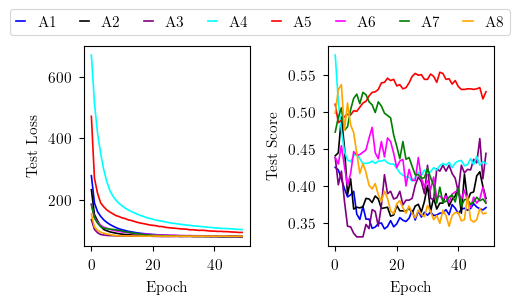

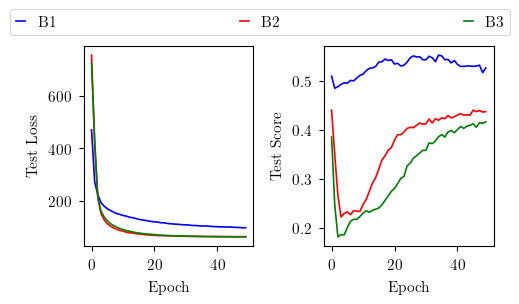

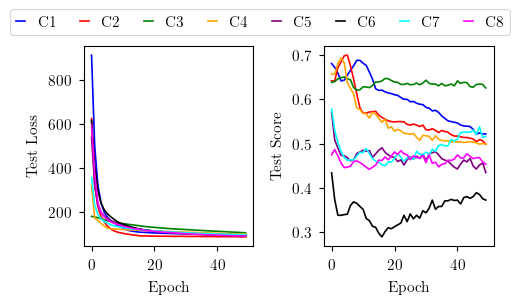

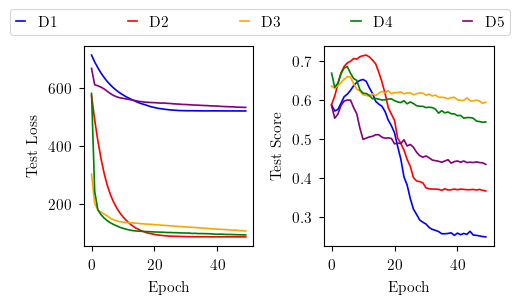

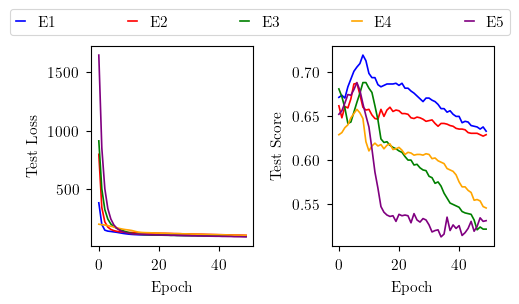

In [28]:
def plot_trajectories(fig, ax, test_index, color, label=None):
    av_train_loss = 0
    av_test_loss = 0
    av_score = 0
    for i in range(5):
        train_loss, test_loss, score = np.loadtxt(f'results_2d_autoencoder/test_{test_index}_iter_{i}.txt', unpack=True)
        av_train_loss += train_loss
        av_test_loss += test_loss
        av_score += score
    ax[0].plot(av_test_loss/5, color=color, label = label)
    ax[1].plot(av_score/5, color=color)
    ax[0].set_xlabel('Epoch')
    ax[1].set_xlabel('Epoch')
    ax[0].set_ylabel('Test Loss')
    ax[1].set_ylabel('Test Score')
    
    
fig,ax = plt.subplots(1,2)
plot_trajectories(fig, ax, 1, 'blue', 'A1')
plot_trajectories(fig, ax, 6, 'black', 'A2')
plot_trajectories(fig, ax, 5, 'purple', 'A3')
plot_trajectories(fig, ax, 7, 'cyan', 'A4')
plot_trajectories(fig, ax, 2, 'red', 'A5')
plot_trajectories(fig, ax, 8, 'magenta', 'A6')
plot_trajectories(fig, ax, 3, 'green', 'A7')
plot_trajectories(fig, ax, 4, 'orange', 'A8')
fig.legend(bbox_to_anchor=(0., 0.98, 1., .102), loc='lower left',
                      ncols=8, mode="expand", borderaxespad=0., handlelength=0.6)
fig.tight_layout()
fig.savefig('latex/images/plots/defect_detection_A.pdf', bbox_inches='tight')
# fig.suptitle('Which LR and Dropout to choose?')
# ^ DO and lr tests --> DO and lr 0.001 seem to be the best
fig,ax = plt.subplots(1,2)
plot_trajectories(fig, ax, 2, 'blue', 'B1')
plot_trajectories(fig, ax, 10, 'red', 'B2')
plot_trajectories(fig, ax, 12, 'green', 'B3')
fig.legend(bbox_to_anchor=(0., 0.98, 1., .102), loc='lower left',
                      ncols=3, mode="expand", borderaxespad=0., handlelength=0.6)
fig.tight_layout()
fig.savefig('latex/images/plots/defect_detection_B.pdf', bbox_inches='tight')
# ^ Use all features
fig,ax = plt.subplots(1,2)
plot_trajectories(fig, ax, 21, 'blue', 'C1')
plot_trajectories(fig, ax, 22, 'red', 'C2')
plot_trajectories(fig, ax, 23, 'green', 'C3')
plot_trajectories(fig, ax, 24, 'orange', 'C4')
plot_trajectories(fig, ax, 25, 'purple', 'C5')
plot_trajectories(fig, ax, 26, 'black', 'C6')
plot_trajectories(fig, ax, 27, 'cyan', 'C7')
plot_trajectories(fig, ax, 28, 'magenta', 'C8')
fig.legend(bbox_to_anchor=(0., 0.98, 1., .102), loc='lower left',
                      ncols=8, mode="expand", borderaxespad=0., handlelength=0.6)
fig.tight_layout()
fig.savefig('latex/images/plots/defect_detection_C.pdf', bbox_inches='tight')
# ^ Different structures --> GCNConv 6531 seems to be the best
fig,ax = plt.subplots(1,2)
plot_trajectories(fig, ax, 13, 'blue', 'D1')
plot_trajectories(fig, ax, 14, 'red', 'D2')
plot_trajectories(fig, ax, 16, 'orange', 'D3')
plot_trajectories(fig, ax, 15, 'green', 'D4')
plot_trajectories(fig, ax, 17, 'purple', 'D5')
fig.legend(bbox_to_anchor=(0., 0.98, 1., .102), loc='lower left',
                      ncols=5, mode="expand", borderaxespad=0., handlelength=0.6)
fig.tight_layout()
fig.savefig('latex/images/plots/defect_detection_D.pdf', bbox_inches='tight')
# plot_trajectories(fig, ax, 18, 'black', 'GINEConv: attr sigmoid, str sigmoid')
# plot_trajectories(fig, ax, 9, 'cyan', 'GINEConv: attr sigmoid, str none')
# # Misses relu none
# plot_trajectories(fig, ax, 19, 'magenta', 'GINEConv: attr relu, str relu')
# plot_trajectories(fig, ax, 20, 'brown', 'GINEConv: attr relu, str sigmoid')
# ^ GCNConv and GINEConv tests --> GCNConv relu relu seems to be better
fig,ax = plt.subplots(1,2)
plot_trajectories(fig, ax, 29, 'blue', r'E1')
plot_trajectories(fig, ax, 30, 'red', r'E2')
plot_trajectories(fig, ax, 21, 'green', r'E3')
plot_trajectories(fig, ax, 31, 'orange', r'E4')
plot_trajectories(fig, ax, 32, 'purple', r'E5')
fig.legend(bbox_to_anchor=(0., 0.98, 1., .102), loc='lower left',
                      ncols=5, mode="expand", borderaxespad=0., handlelength=0.6)
fig.tight_layout()
fig.savefig('latex/images/plots/defect_detection_E.pdf', bbox_inches='tight')
# plot_trajectories(fig, ax, 33, 'black', r'GINEConv: $\alpha=0.3$')
# plot_trajectories(fig, ax, 34, 'cyan', r'GINEConv: $\alpha=0.4$')
# plot_trajectories(fig, ax, 25, 'magenta', r'GINEConv: $\alpha=0.5$')
# plot_trajectories(fig, ax, 35, 'brown', r'GINEConv: $\alpha=0.6$')
# plot_trajectories(fig, ax, 36, 'grey', r'GINEConv: $\alpha=0.7$')
# ^ Different alphas --> 0.3 seems to be the best

## Tests for Mail to Jonas - Not suitable for report

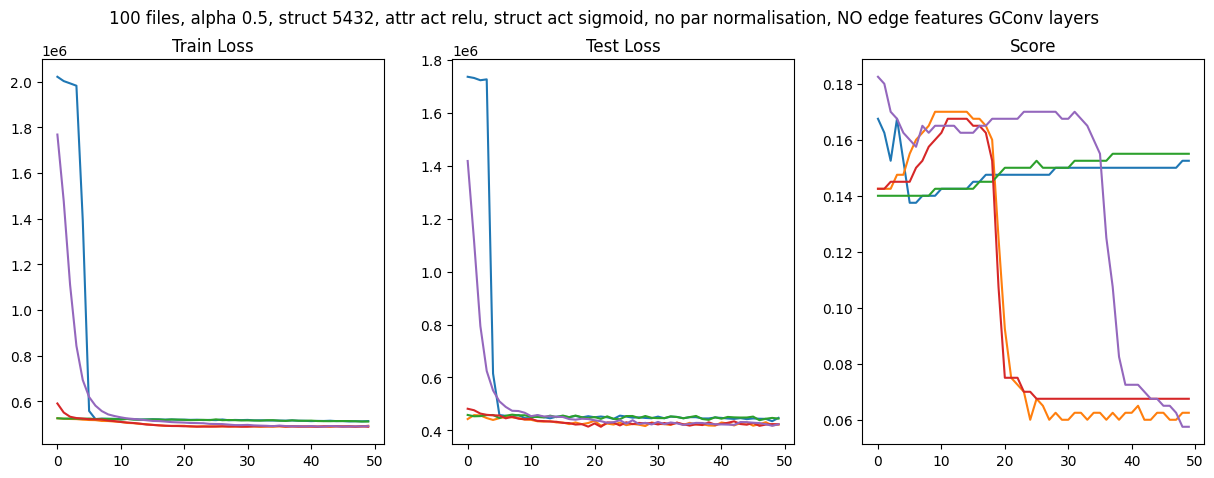

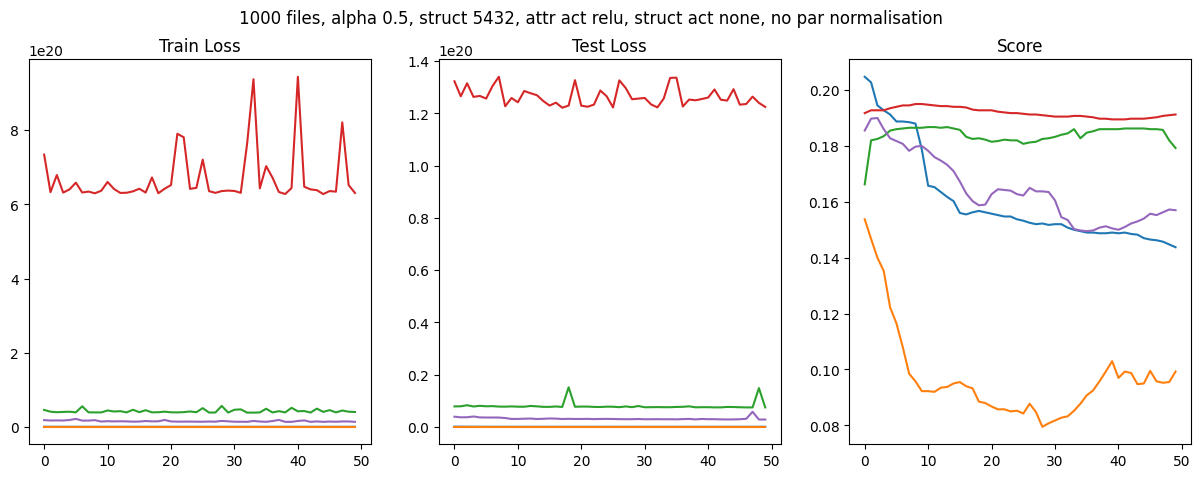

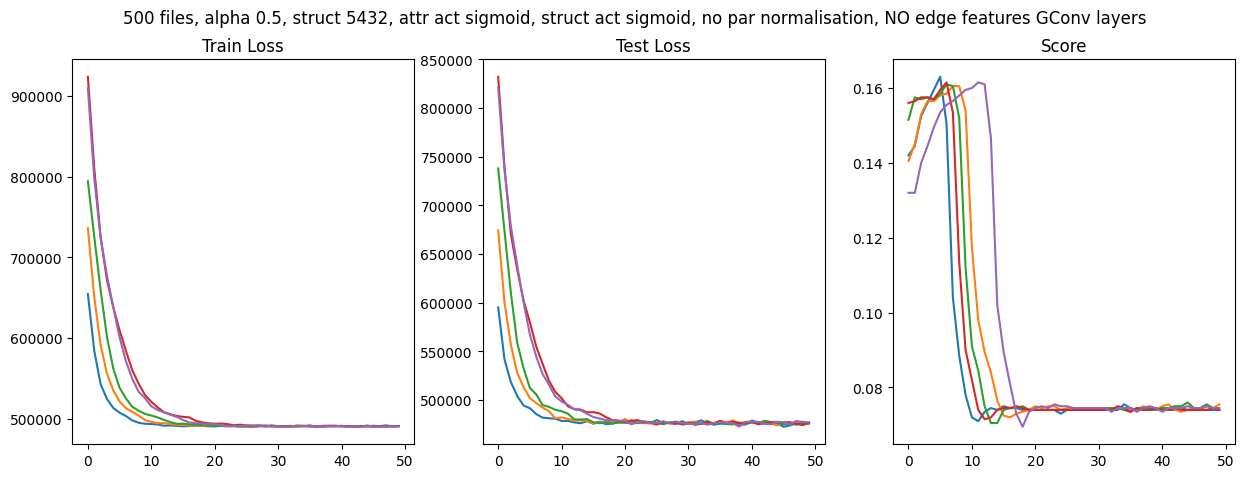

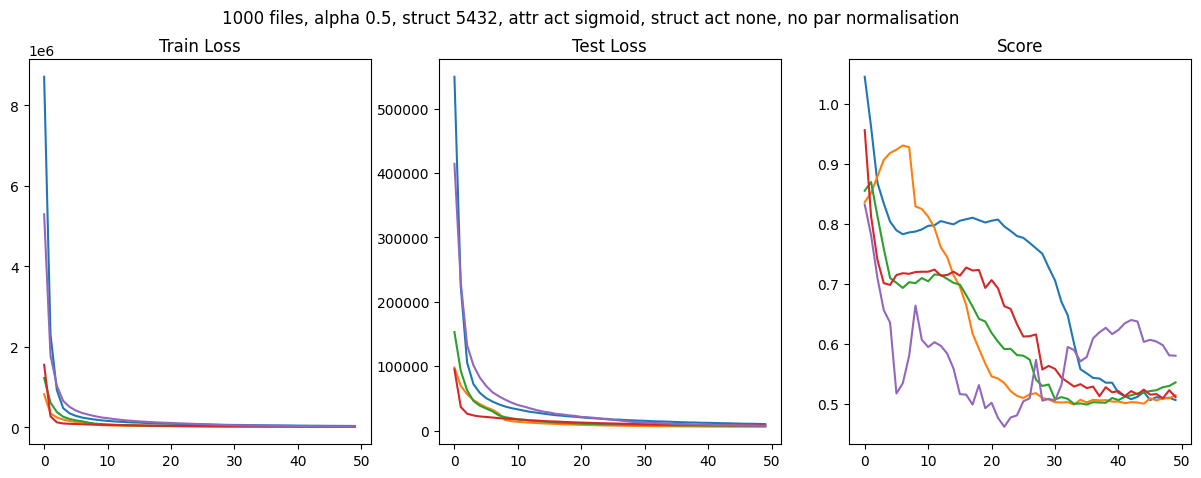

In [24]:
fig,ax = plt.subplots(ncols=3, figsize = (15,5))
for i in range(5):
    train_loss, test_loss, score = np.loadtxt(f'results_2d_autoencoder/test_1_iter_{i}.txt').T
    ax[0].plot(train_loss, label='Train Loss', color=cmap[i])
    ax[1].plot(test_loss, label='Test Loss', color=cmap[i])
    ax[2].plot(score, label='Score', color=cmap[i])
    ax[0].set_title('Train Loss')
    ax[1].set_title('Test Loss')
    ax[2].set_title('Score')
    fig.suptitle('100 files, alpha 0.5, struct 5432, attr act relu, struct act sigmoid, no par normalisation, NO edge features GConv layers')
    
fig,ax = plt.subplots(ncols=3, figsize = (15,5))
for i in range(5):
    train_loss, test_loss, score = np.loadtxt(f'2d_autoencoder_tests/test_2_iter_{i}.txt').T
    ax[0].plot(train_loss, label='Train Loss', color=cmap[i])
    ax[1].plot(test_loss, label='Test Loss', color=cmap[i])
    ax[2].plot(score, label='Score', color=cmap[i])
    ax[0].set_title('Train Loss')
    ax[1].set_title('Test Loss')
    ax[2].set_title('Score')
    fig.suptitle('1000 files, alpha 0.5, struct 5432, attr act relu, struct act none, no par normalisation')
    
fig,ax = plt.subplots(ncols=3, figsize = (15,5))
for i in range(5):
    train_loss, test_loss, score = np.loadtxt(f'2d_autoencoder_tests/test_3_iter_{i}.txt').T
    ax[0].plot(train_loss, label='Train Loss', color=cmap[i])
    ax[1].plot(test_loss, label='Test Loss', color=cmap[i])
    ax[2].plot(score, label='Score', color=cmap[i])
    ax[0].set_title('Train Loss')
    ax[1].set_title('Test Loss')
    ax[2].set_title('Score')
    fig.suptitle('500 files, alpha 0.5, struct 5432, attr act sigmoid, struct act sigmoid, no par normalisation, NO edge features GConv layers')
    
fig,ax = plt.subplots(ncols=3, figsize = (15,5))
for i in range(5):
    train_loss, test_loss, score = np.loadtxt(f'2d_autoencoder_tests/test_4_iter_{i}.txt').T
    ax[0].plot(train_loss, label='Train Loss', color=cmap[i])
    ax[1].plot(test_loss, label='Test Loss', color=cmap[i])
    ax[2].plot(score, label='Score', color=cmap[i])
    ax[0].set_title('Train Loss')
    ax[1].set_title('Test Loss')
    ax[2].set_title('Score')
    fig.suptitle('1000 files, alpha 0.5, struct 5432, attr act sigmoid, struct act none, no par normalisation')
    
# TODO: the scores from colab were calculated by dividing through len(train_loader.dataset) instead of len(test_loader.dataset) -> fix this
# TODO: score > 1 is not possible, check if the scores are calculated correctly